Retail Analysis examples
======================
Simple TenFrame examples for some basic analysis, to show how familiar it is for python users, and to demonstrate performance on a large dataset.

Load iris
----------

In [2]:
load_ext iris

Import libraries
------------------

In [11]:
import py1010
import tenFrame as tf
import pandas as pd
import numpy as np
tf.useiris(False)

session = py1010.Session("1010data URL", "USERNAME", "PASSWORD", py1010.POSSESS)

In [4]:
sales = tf.TenFrame(session, "retaildemo.retail.sales_detail")
# without downsampling, describe() below takes about 6 minutes.  Plan accordingly.
# sales = sales.sample(frac=1e-3)
print(f"Total sales rows: {len(sales):,}")
# Sales linked with customer data, filtered to rows where such data exists.
salescust = tf.merge(sales, "retaildemo.retail.customers", on="customer_key")
salescust.dropna(subset=["customer_key"], inplace=True)
print(f"Rows with known customers: {len(salescust):,}")
# Sales linked with product data
salesprod = tf.merge(sales, "retaildemo.retail.products", on="sku")

Total sales rows: 5,997,373,902
Rows with known customers: 836,621,077


Overview of data
--------------------
We can just do the usual `describe()` method for an overview of the sales data.

In [12]:
%%time
sales.describe(exclude=["transid", "date", "tme", "sku", "store", "customer_key", "promo_flag"])

CPU times: user 32 ms, sys: 19.2 ms, total: 51.1 ms
Wall time: 445 ms


qty        weight        xsales         price          cost
count   5.997374e+09  5.997374e+09  5.997374e+09  5.997374e+09  5.997024e+09
mean    1.356727e+00  1.144611e+00  3.895354e+00  3.153982e+00  2.675612e+00
std_s   1.252325e+00  8.808362e-01  4.493964e+00  3.159839e+00  3.375028e+00
min    -9.900000e+01 -1.066300e+02 -4.227208e+04 -9.717720e+03 -2.954677e+04
lquart  1.000000e+00  1.000000e+00  1.770000e+00  1.370000e+00  1.070000e+00
median  2.000000e+00  1.000000e+00  2.870000e+00  2.500000e+00  1.920000e+00
uquart  2.000000e+00  1.420000e+00  4.650000e+00  3.870000e+00  3.090000e+00
max     9.900000e+01  1.200000e+02  8.997500e+02  1.999900e+02  2.705800e+03

More detailed overview
----------------------------
The following shows an overview at a slightly more granular level, with customer data.

In [13]:
%%time
salescust.groupby("gender").describe(exclude=["transid", "date", "tme", "sku", "store", "customer_key", "promo_flag", "birthdate", "customerid", "tier"])
# (the short and very very wide format is what pandas does as well.)

CPU times: user 39.4 ms, sys: 11 ms, total: 50.5 ms
Wall time: 617 ms


gender    qty_count  qty_mean  qty_std_s  qty_min  qty_lquart  qty_median  \
0      M  176834985.0  1.310697   0.962674    -82.0         1.0         1.0   
1      F  566190126.0  1.309058   0.958930    -89.0         1.0         1.0   
2   <NA>   93595966.0  1.398271   1.185352    -70.0         1.0         1.0   

   qty_uquart  qty_max  weight_count  ...  cost_uquart  cost_max    age_count  \
0         1.0     99.0   176834985.0  ...         3.21    765.69  176834985.0   
1         1.0     99.0   566190126.0  ...         3.20    824.12  566190126.0   
2         1.0     99.0    93595966.0  ...         3.26    712.15   93595966.0   

    age_mean  age_std_s  age_min  age_lquart  age_median  age_uquart  age_max  
0  47.831535  10.575100       18          41          48          55       92  
1  47.765438  10.659013       18          41          48          55       96  
2  46.804938  10.590270       17          40          47          54       94  

[3 rows x 49 columns]

Count of transactions by date
-----------------------------------

In [14]:
%%time
r = sales.groupby("date").transid.cnt()
r.printprettyXML()
q = r.iloc[0]       # Something to make the time shown honest.
r

<?xml version="1.0" ?>
<macro>
	<base table="retaildemo.retail.sales_detail"/>
	<willbe value="g_cnt((date);())" name="transid_cnt"/>
	<sel value="g_first1(date;;)"/>
	<colord cols="date,transid_cnt"/>
</macro>

CPU times: user 18.3 ms, sys: 10.5 ms, total: 28.8 ms
Wall time: 1.16 s


date  transid_cnt
0  2012-12-31      3332409
1  2013-01-01      1912203
2  2013-01-02      2374098
3  2013-01-03      2403905
4  2013-01-04      2512208
5  2013-01-05      2792596
6  2013-01-06      3134535
7  2013-01-07      2659785
8  2013-01-08      2425479
9  2013-01-09      2338966

Total sales by date
----------------------

In [15]:
%%time
r = sales.groupby("date")['xsales'].sum()
r.printprettyXML()
q = r.iloc[0]
r

<?xml version="1.0" ?>
<macro>
	<base table="retaildemo.retail.sales_detail"/>
	<willbe value="g_sum((date);();(xsales))" name="xsales_sum"/>
	<sel value="g_first1(date;;)"/>
	<colord cols="date,xsales_sum"/>
</macro>

CPU times: user 22.5 ms, sys: 11.3 ms, total: 33.8 ms
Wall time: 1.33 s


date    xsales_sum
0  2012-12-31  1.335217e+07
1  2013-01-01  6.713122e+06
2  2013-01-02  8.270888e+06
3  2013-01-03  8.443139e+06
4  2013-01-04  9.015836e+06
5  2013-01-05  1.000415e+07
6  2013-01-06  1.086893e+07
7  2013-01-07  9.230439e+06
8  2013-01-08  8.493609e+06
9  2013-01-09  8.253537e+06

Transactions, total sales, and sales per transaction, by customer
-----------------------------------------------------------------------------

In [16]:
%%time
r = salescust.groupby("customer_key").agg({"transid":"count", "xsales":"sum"})
r['sales_per_trans'] = r['xsales_sum'] / r['transid_count']
r.printprettyXML()
q = r.iloc[0]
r

<?xml version="1.0" ?>
<macro>
	<base table="retaildemo.retail.sales_detail"/>
	<link table2="retaildemo.retail.customers" col="customer_key" type="exact"/>
	<sel value="~(r_nacnt(customer_key;) >= 1)"/>
	<tabu breaks="customer_key">
		<tcol name="transid_count" source="transid" fun="valcnt"/>
		<tcol name="xsales_sum" source="xsales" fun="sum"/>
	</tabu>
	<willbe name="sales_per_trans" value="((xsales_sum) / (transid_count))"/>
</macro>

CPU times: user 40.5 ms, sys: 20.3 ms, total: 60.8 ms
Wall time: 1.38 s


customer_key  transid_count  xsales_sum  sales_per_trans
0             1          776.0     3268.82         4.212397
1             2         1131.0     2518.92         2.227162
2             3         1754.0     5529.91         3.152742
3             4         1721.0     5131.60         2.981755
4             5         2743.0     8399.06         3.061998
5             6         1961.0     9066.47         4.623391
6             7          153.0     1339.69         8.756144
7             8          198.0      523.50         2.643939
8             9         1177.0     4034.91         3.428131
9            10          618.0     1840.90         2.978803

Charting examples
-----------------------
 1. Bar chart on total sales by gender.
 2. Histogram on age.
 3. Bar chart on number of transactions by age group.
 4. Bar chart on total sales by age group.

CPU times: user 952 ms, sys: 449 ms, total: 1.4 s
Wall time: 1min 48s


<AxesSubplot:xlabel='age_group'>

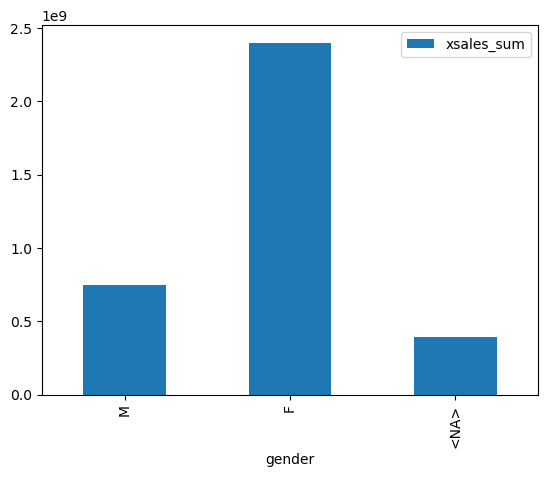

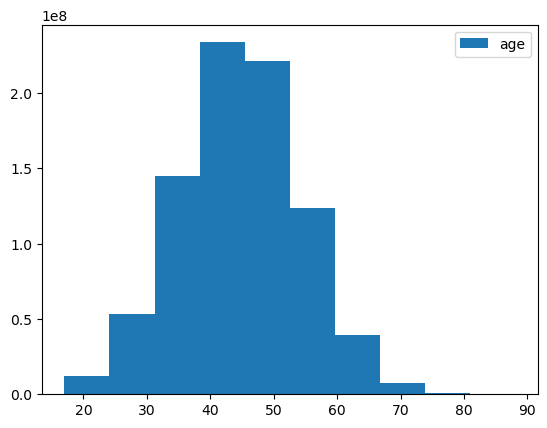

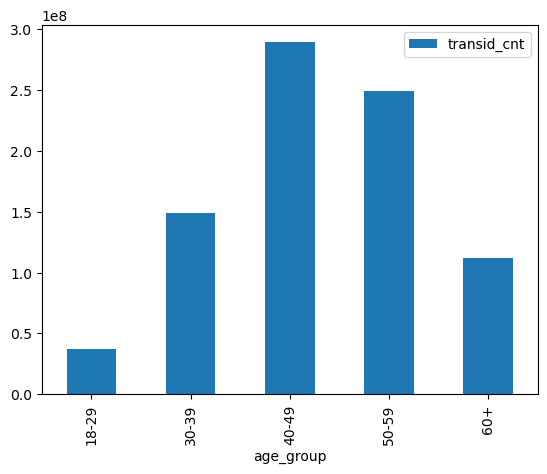

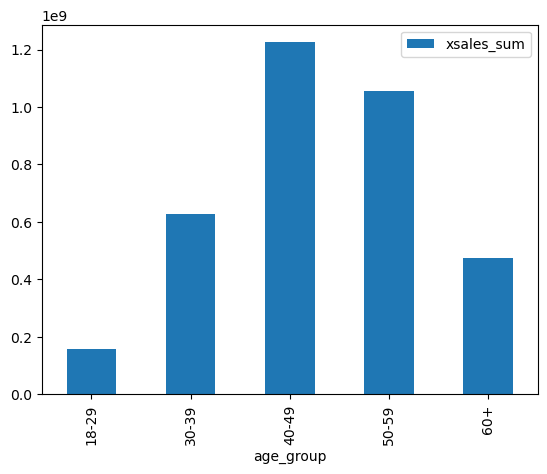

In [17]:
%%time
salescust.groupby("gender")['xsales'].sum().plot(kind="bar", x="gender", y="xsales_sum")
salescust[['age']].plot(kind="hist")
salescust.groupby("age_group").transid.cnt().sort_values("age_group").plot(kind="bar", x="age_group", y="transid_cnt")
salescust.groupby("age_group").xsales.sum().sort_values("age_group").plot(kind="bar", x="age_group", y="xsales_sum")

Now, a line graph of total sales by date, and a histogram of total sales by date.

CPU times: user 234 ms, sys: 13 ms, total: 247 ms
Wall time: 3.81 s


[('', <Axes: >)]

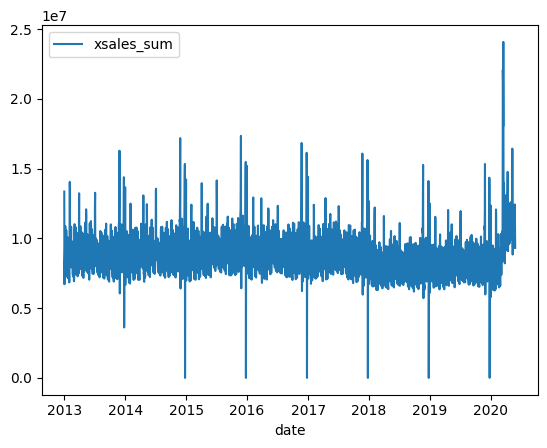

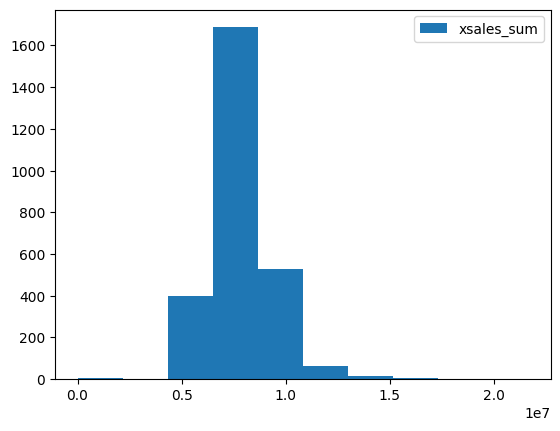

In [11]:
%%time 
sales.groupby("date").xsales.sum().plot(kind="line", x="date", y="xsales_sum")
sales.groupby("date").xsales.sum()[['xsales_sum']].plot(kind="hist")

CPU times: user 124 ms, sys: 7.26 ms, total: 132 ms
Wall time: 1.74 s


<Axes: xlabel='date'>

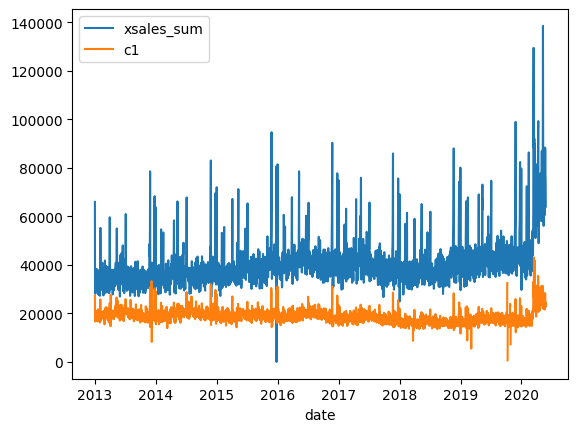

In [12]:
%%time
# Once you've done the aggregation by date, the data is small enough
# that you could just bring it into pandas and work with it directly.
rr = sales[sales.store == 937].groupby("date").xsales.sum()
rr2 = rr.merge(sales[sales.store == 728].groupby("date").xsales.sum(), on="date")
rr2.plot(kind="line", x="date", y=["xsales_sum", "c1"])